In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import NMF

import utils.sulfur.constant as const
from utils.CaImageCSV import CaImageCSV
from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer
from utils.useful_tool import find_all_nan_cells, dropped_unique_cells

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def split_engram_matrix(animal_name, context_name):
    csv = ContextDataCSV(animal_name, context_name)
    matrix = csv.data_frame
    matrix = MatrixOptimizer(matrix).divide_sd()
    
    engram_df = matrix.loc[:, csv.engram_cells()]
    non_engram_df = matrix.loc[:, csv.non_engram_cells()]
    
    return engram_df, non_engram_df

def split_matrix(matrix, context_name):
    matrix_1 = matrix.iloc[0:400, :]
    matrix_2 = matrix.iloc[900:1300, :]
    matrix_3 = matrix.iloc[1800:2200, :]
    
    return matrix_1, matrix_2, matrix_3

def AICc(distance, K, N):
    return 2 * distance + 2 * K * (N / (N - K - 1)) # 対数尤度=-Dis(x,y) より 

def setted_NMF(df, components_size):
    model = NMF(n_components=components_size, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu', max_iter=2000)
    model.fit(df)
    W = model.transform(df)
    H = model.components_
    
    return W, H, model

def calc_matching_score(base_pattern_vectors, comp_pattern_vectors):
    threshold = 0.6
    similarities = cosine_similarity(base_pattern_vectors, comp_pattern_vectors)
    matching_score = 0
    for similarity in similarities:
        if len(similarity[similarity > threshold]) > 0:
            matching_score += 1
        
    return matching_score / len(base_pattern_vectors)
    
def build_pattern_vectors(dfs):
    patterns = {}
    for context_name, df in dfs.items():
        min_aic_value = float('inf')
        min_H = None
        upper_count = 0
        
        for n in range(1, len(df.columns) + 1):
            _, H, model = setted_NMF(df, n)
            err = model.reconstruction_err_
            aic_value = AICc(err, n, len(columns) * len(df))
            if min_aic_value > aic_value:
                upper_count = 0
                min_aic_value = aic_value
                min_H = H
                
            if min_aic_value < aic_value:
                upper_count += 1
                
            if upper_count > 20:
                break
                
        patterns[context_name] = min_H
        
    return patterns

In [6]:
%%time

columns = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
shuffled_count = 100

animal_name = const.ANIMAL_NAMES[0]
print('animal_name: %s' % animal_name)

a1_csv = ContextDataCSV(animal_name, 'A1postES')
a1_matrix = a1_csv.data_frame
a1_matrix = MatrixOptimizer(a1_matrix).divide_sd()

a4_csv = ContextDataCSV(animal_name, 'A4postES')
a4_matrix = a4_csv.data_frame
a4_matrix = MatrixOptimizer(a4_matrix).divide_sd()

a1_nan_cells = find_all_nan_cells(a1_matrix)
a4_nan_cells = find_all_nan_cells(a4_matrix)

dropped_cells = dropped_unique_cells(a1_nan_cells, a4_nan_cells)
a1_matrix.drop(columns=dropped_cells, inplace=True)
a4_matrix.drop(columns=dropped_cells, inplace=True)

shuffle_engram_matching_score = pd.DataFrame(index=list(range(shuffled_count)), columns=columns)

for index in range(shuffled_count):
    random_cells = np.random.randint(0, len(a1_matrix.columns), size=len(a1_csv.engram_cells()))
    a1_shuffle_df = a1_matrix.iloc[:, random_cells].copy(deep=True)
    a4_shuffle_df = a4_matrix.iloc[:, random_cells].copy(deep=True)
    
    shuffled_a1_1, shuffled_a1_2, shuffled_a1_3 = split_matrix(a1_shuffle_df, 'A1postES')
    shuffled_a4_1, shuffled_a4_2, shuffled_a4_3 = split_matrix(a4_shuffle_df, 'A4postES')
    
    
    shuffled_df = {}
    shuffled_df['A1_1'] = shuffled_a1_1
    shuffled_df['A1_2'] = shuffled_a1_2
    shuffled_df['A1_3'] = shuffled_a1_3
    shuffled_df['A4_1'] = shuffled_a4_1
    shuffled_df['A4_2'] = shuffled_a4_2
    shuffled_df['A4_3'] = shuffled_a4_3
    
    shuffled_patterns = {}
    for context_name, df in shuffled_df.items():
        _, H, _ = setted_NMF(df, len(df.columns) - 1)
        shuffled_patterns[context_name] = H
    
    shuffle_engram_matching_score.loc[index, 'A1_1'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_1'])
    shuffle_engram_matching_score.loc[index, 'A1_2'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_2'])
    shuffle_engram_matching_score.loc[index, 'A1_3'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A1_3'])
    shuffle_engram_matching_score.loc[index, 'A4_1'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_1'])
    shuffle_engram_matching_score.loc[index, 'A4_2'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_2'])
    shuffle_engram_matching_score.loc[index, 'A4_3'] = calc_matching_score(shuffled_patterns['A1_1'], shuffled_patterns['A4_3'])
    
shuffle_engram_matching_score

animal_name: ID181106CreA
CPU times: user 32min 16s, sys: 26 s, total: 32min 42s
Wall time: 5min 28s


,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
0,1.0,0.678571,0.732143,0.660714,0.607143,0.553571
1,1.0,0.714286,0.714286,0.714286,0.607143,0.571429
2,1.0,0.625,0.678571,0.696429,0.714286,0.660714
3,1.0,0.75,0.732143,0.767857,0.660714,0.678571
4,1.0,0.732143,0.732143,0.803571,0.696429,0.839286
...,...,...,...,...,...,...
95,1.0,0.678571,0.714286,0.464286,0.553571,0.553571
96,1.0,0.571429,0.75,0.714286,0.75,0.642857
97,1.0,0.714286,0.660714,0.732143,0.642857,0.714286
98,1.0,0.714286,0.607143,0.642857,0.571429,0.553571


(array([ 3.,  3.,  7., 15., 34., 17., 18.,  3.]),
 array([0.5178571428571429, 0.5580357142857143, 0.5982142857142858,
        0.6383928571428572, 0.6785714285714286, 0.71875,
        0.7589285714285714, 0.7991071428571429, 0.8392857142857143],
       dtype=object),
 <BarContainer object of 8 artists>)

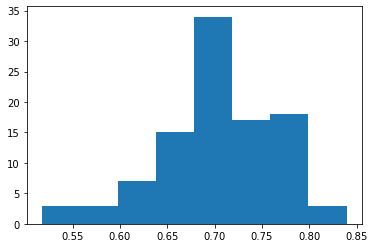

In [11]:
plt.hist(shuffle_engram_matching_score.loc[:, 'A1_2'], bins=8)

In [12]:
from matching_score_resampling import MatchingScoreResampling

In [13]:
mc = MatchingScoreResampling()
fit = mc.resampling(shuffle_engram_matching_score.loc[:, 'A1_2'])
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd71cdd6da0ab5f91b96805ab7873f3e NOW.


Inference for Stan model: anon_model_dd71cdd6da0ab5f91b96805ab7873f3e.
3 chains, each with iter=1000; warmup=300; thin=1; 
post-warmup draws per chain=700, total post-warmup draws=2100.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       0.7  2.2e-4 6.6e-3   0.69    0.7    0.7   0.71   0.72    905   1.01
sigma   0.06  1.1e-4 4.5e-3   0.05   0.06   0.06   0.07   0.07   1659    1.0
lp__  227.18    0.04   1.05 224.19 226.77  227.5 227.94 228.21    715    1.0

Samples were drawn using NUTS at Sun Aug 22 03:45:16 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [16]:
np.mean(fit.extract('mu')['mu'])

0.7028326833176806

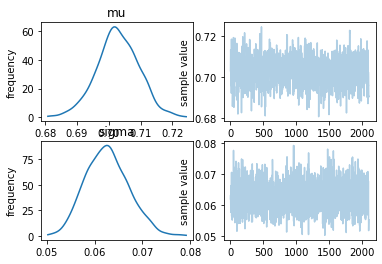

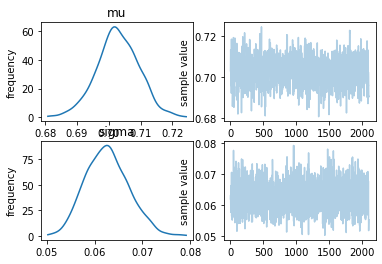

In [17]:
fit.plot()

In [18]:
results

{'A1_1': array([1., 1., 1., ..., 1., 1., 1.]),
 'A1_2': array([0.70547495, 0.70341867, 0.69731859, ..., 0.70527298, 0.71136246,
        0.69357128]),
 'A1_3': array([0.6842661 , 0.67888732, 0.68448561, ..., 0.68424055, 0.6854942 ,
        0.67844822]),
 'A4_1': array([0.6832856 , 0.67408584, 0.68712123, ..., 0.68759732, 0.6934114 ,
        0.69875363]),
 'A4_2': array([0.63644719, 0.64293546, 0.63588851, ..., 0.63729261, 0.65279873,
        0.64406722]),
 'A4_3': array([0.66561843, 0.64632931, 0.65043737, ..., 0.67010748, 0.6535319 ,
        0.6288488 ])}